In [102]:
from utils import TECGDataModule
from tqdm import tqdm
import pandas as pd
import torch
import numpy as np
from GAN_Arch_details import CycleGAN_Unet_Generator

In [103]:
import pandas as pd

from app.ecg.ecg import EcgDataset

from torch_ecg.augmenters import BaselineWanderAugmenter
from app.ecg.ecg import EcgSignal

ptbxl_data = pd.read_csv(r'C:\Users\baev-\PycharmProjects\ecg-service\data\ptbxl\labels.csv', index_col=0)

ptbxl_data.info()

def get_file_paths(filename):
    filename_lr = filename.split('/')[-1].split('_')[0]
    return fr"C:\Users\baev-\PycharmProjects\ecg-service\data\ptbxl\npy_signals100\{filename_lr}.npy"


clean_tags = lambda x: [e.replace("'", "") for e in x[1:-1].split(', ')]
ptbxl_data["file_paths"] = ptbxl_data["filename_lr"].apply(get_file_paths)
ptbxl_data["superdiagnostic"] = ptbxl_data["superdiagnostic"].apply(clean_tags)
#ptbxl_data

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(ptbxl_data["superdiagnostic"].values)
mlb.classes_.tolist()

train_labels = mlb.transform(ptbxl_data["superdiagnostic"].tolist())
ptbxl_data[mlb.classes_.tolist()] = train_labels


valid_df = ptbxl_data[ptbxl_data['strat_fold'] == 9]
test_df = ptbxl_data[ptbxl_data['strat_fold'] == 10]

dataset = EcgDataset(ptbxl_data)
valid_dataset = EcgDataset(valid_df)
test_dataset = EcgDataset(test_df)


<class 'pandas.core.frame.DataFrame'>
Index: 21388 entries, 15709.0 to 11744.0
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           21388 non-null  float64
 1   sex                           21388 non-null  int64  
 2   height                        6918 non-null   float64
 3   weight                        9366 non-null   float64
 4   nurse                         19949 non-null  float64
 5   site                          21372 non-null  float64
 6   device                        21388 non-null  object 
 7   recording_date                21388 non-null  object 
 8   report                        21388 non-null  object 
 9   scp_codes                     21388 non-null  object 
 10  heart_axis                    13228 non-null  object 
 11  infarction_stadium1           5600 non-null   object 
 12  infarction_stadium2           103 non-null    object 
 13

C:\Users\baev-\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-S8mQcxkY-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
C:\Users\baev-\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-S8mQcxkY-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)
C:\Users\baev-\AppData\Local\pypoetry\Cache\virtualenvs\ecg-service-S8mQcxkY-py3.12\Lib\site-packages\nnAudio\utils.py:429: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn("If fmax is given, n_bins will be ignored", SyntaxWarning)


In [104]:
def moving_med(x, w):
  armed=[]
  index=w//2
  it=0
  while it+w<len(x):
    if w%2:
      armed.append(sorted(x[it:it+w])[index])
    else:
      armed.append(sum(sorted(x[it:it+w])[index-1:index+1])/2)
    it+=1
  return armed

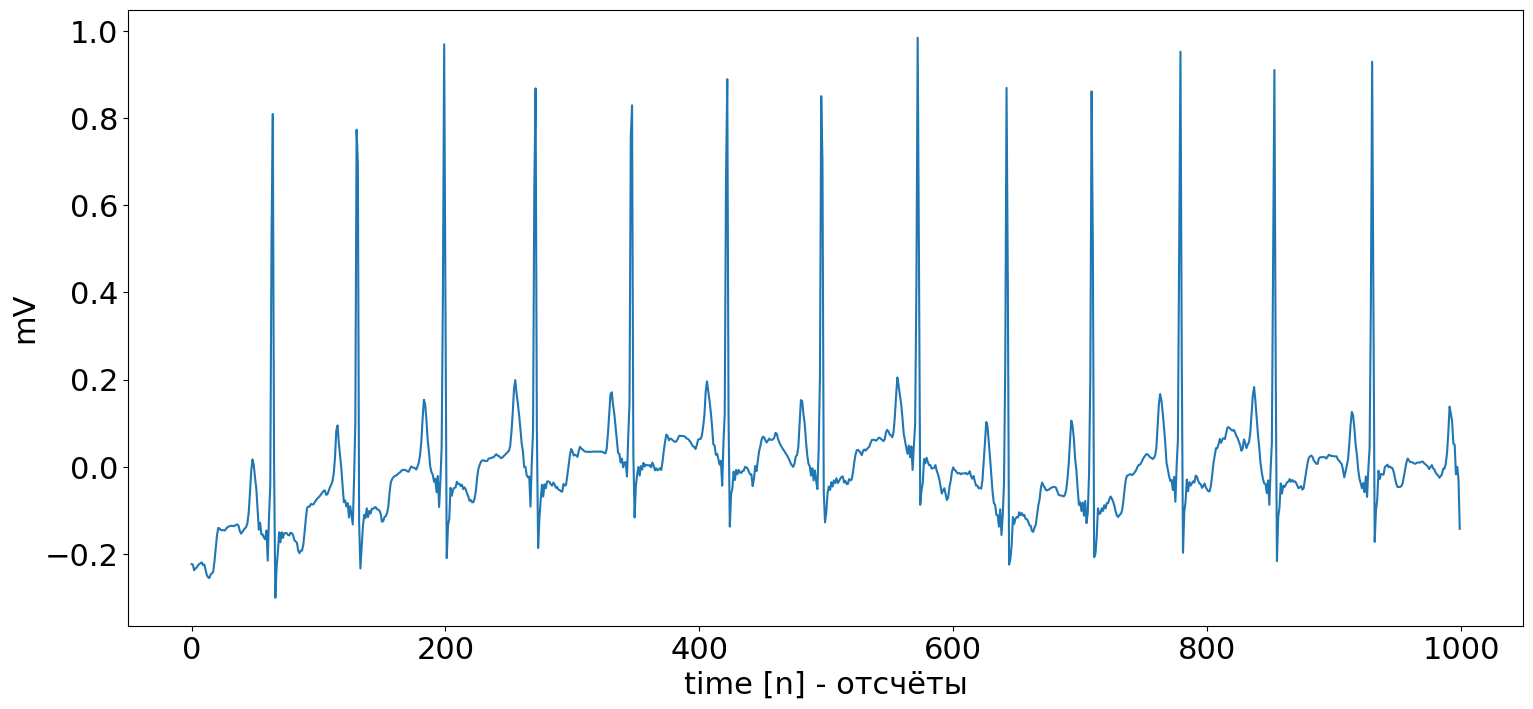

In [105]:

ecg, label = dataset[5]
esig = EcgSignal()
esig.plot_sample(ecg[0][5])

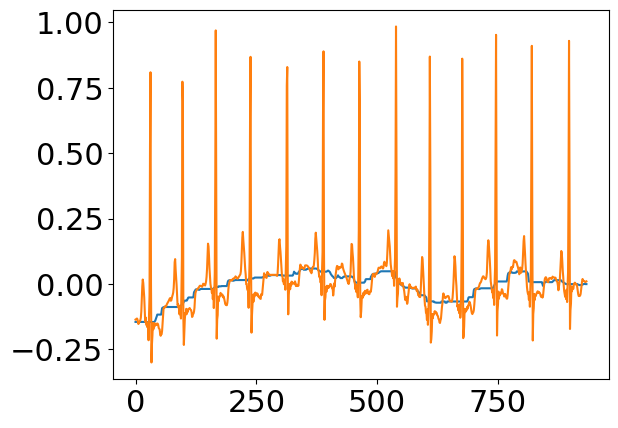

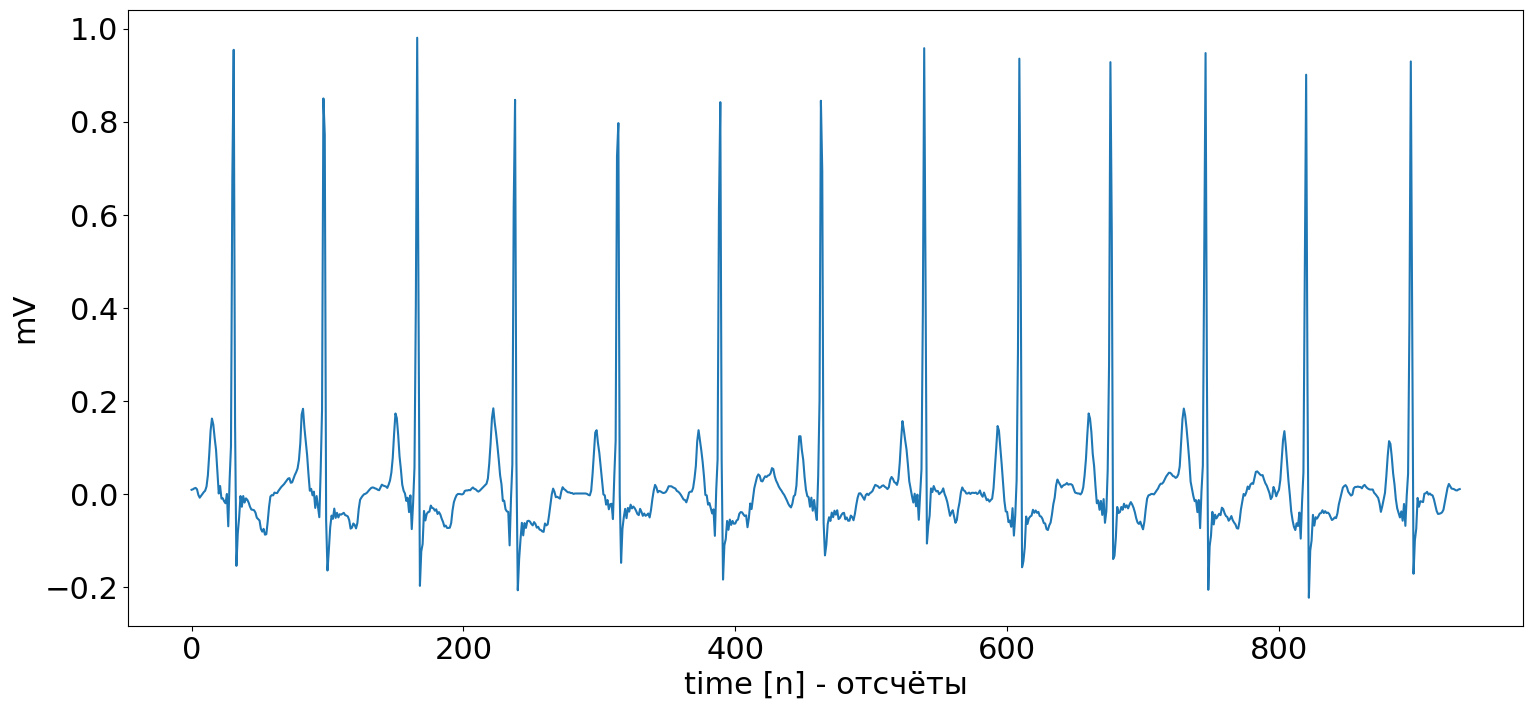

In [106]:
from matplotlib import pyplot as plt

mm=moving_med(np.array(ecg[0][5]),66)
plt.plot(mm)
plt.plot(ecg[0][5].detach().numpy()[33:1000-33])
esig.plot_sample(torch.from_numpy(ecg[0][5].detach().numpy()[33:1000-33]- mm))

In [107]:
#esig.plot_sampleplot_sample(ecg[0][5][33:1000-33] - mm)

(4000,)

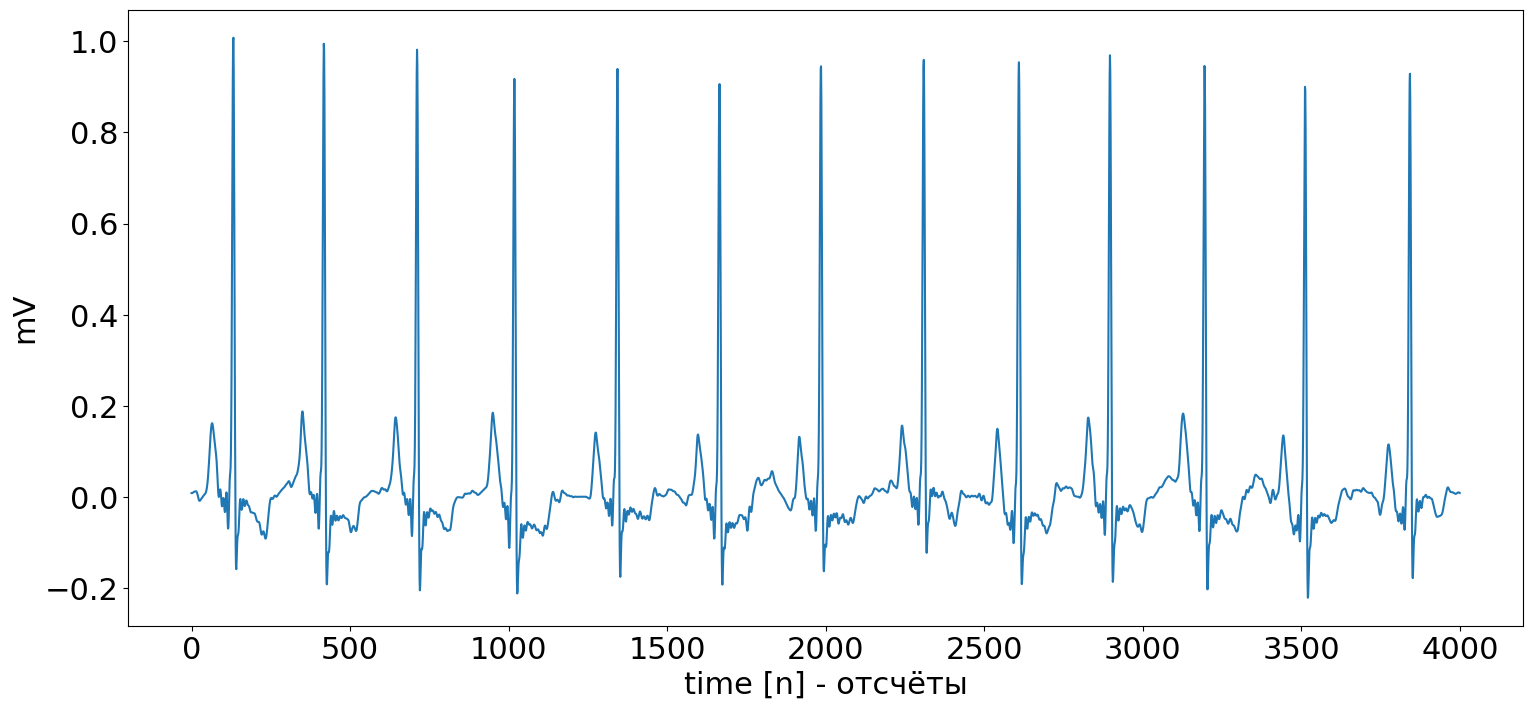

In [108]:
from scipy import signal


new_ecg = signal.resample(torch.from_numpy(ecg[0][5].detach().numpy()[33:1000-33]- mm), 4000)
esig.plot_sample(new_ecg)
new_ecg.shape

In [109]:
new_ecg.shape

(4000,)

In [110]:
G_basestyle = CycleGAN_Unet_Generator()

checkpoint =torch.load("model_weights_16NQ3.pth")

G_basestyle.load_state_dict(checkpoint)

G_basestyle.eval()
G_basestyle.double()
 
#dm = TECGDataModule(data_dir, batch_size, phase='test')
#dm.prepare_data()
#dataloader = dm.train_dataloader()
#train_dat= torch.utils.data.TensorDataset(torch.tensor(test_data_x).to(device), torch.tensor(test_data_y).to(device))


base, style = torch.from_numpy(new_ecg[None,None,:]).to(torch.double), torch.from_numpy(new_ecg[None,None,:]).to(torch.double)
#base, style = torch.rand([8,1,4000]).to(torch.double), torch.rand([8,1,4000]).to(torch.double)
#print('Input Shape {}, {}'.format(base.size(), style.size())) 
#print(type(base))

net = G_basestyle
net.eval()
predicted = []
predicted=pd.DataFrame(data=predicted)
actual = []
actual=pd.DataFrame(data=actual)
output = net(net(base)).squeeze()

In [111]:
output.shape

torch.Size([4000])

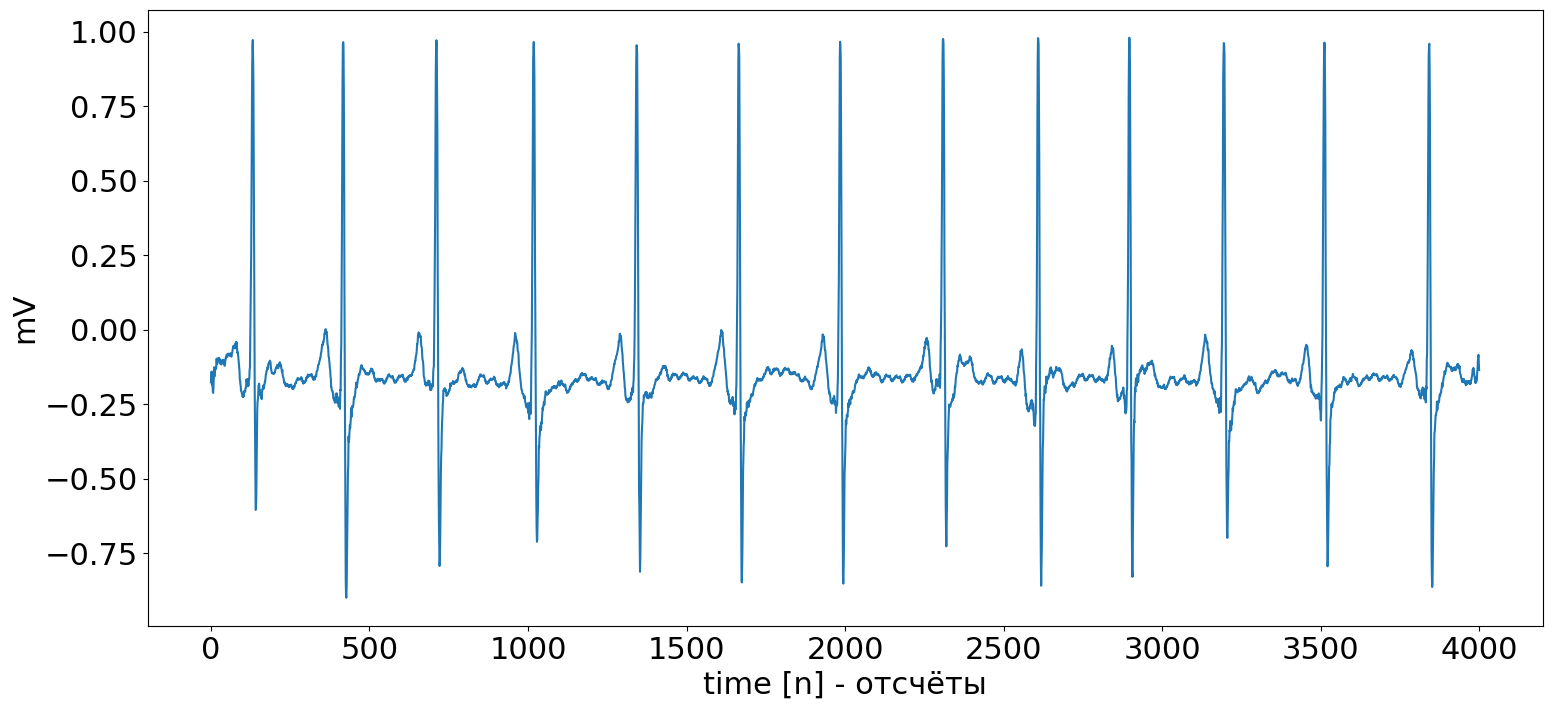

In [112]:
esig.plot_sample(output.detach().numpy())

In [113]:
ecg = np.load(r"C:\Users\baev-\PycharmProjects\ecg-service\data\ptbxl\npy_signals100\00001.npy").T
ecg[0]

array([-0.119, -0.116, -0.12 , -0.117, -0.103, -0.097, -0.119, -0.096,
       -0.048, -0.037, -0.032, -0.002, -0.017, -0.115, -0.156, -0.153,
       -0.143, -0.109, -0.153, -0.178, -0.152,  0.043,  0.469,  0.371,
       -0.002, -0.078, -0.132, -0.132, -0.14 , -0.138, -0.179, -0.18 ,
       -0.119, -0.158, -0.138, -0.117, -0.133, -0.126, -0.149, -0.156,
       -0.139, -0.124, -0.073, -0.078, -0.123, -0.121, -0.062, -0.023,
       -0.024,  0.022,  0.021,  0.011, -0.009, -0.042, -0.048, -0.066,
       -0.088, -0.143, -0.169, -0.17 , -0.19 , -0.184, -0.165, -0.195,
       -0.188, -0.178, -0.186, -0.163, -0.169, -0.138, -0.159, -0.184,
       -0.143, -0.157, -0.126, -0.131, -0.155, -0.143, -0.17 , -0.146,
       -0.157, -0.175, -0.141, -0.158, -0.174, -0.167, -0.168, -0.165,
       -0.158, -0.153, -0.119, -0.113, -0.118, -0.106, -0.149, -0.148,
       -0.132, -0.122, -0.13 , -0.126, -0.051, -0.072, -0.098, -0.081,
       -0.06 , -0.069, -0.106, -0.119, -0.148, -0.129, -0.126, -0.152,
      

In [114]:
ecg.shape

(12, 1000)

In [115]:
def gan_preprocess(ecg : torch.Tensor, inference_count : int) -> torch.Tensor:
  ''' 
  :param ecg: Конкретное отведение ЭКС (4000) 
  :inference_count: Количество применений фильтра
  :return Сгенерированный сигнал
  '''
  ecg = signal.resample(ecg, 4000)
  G_basestyle = CycleGAN_Unet_Generator()
  checkpoint =torch.load("model_weights_16NQ3.pth")
  G_basestyle.load_state_dict(checkpoint)
  G_basestyle.eval()
  G_basestyle.double()
  base, style = torch.from_numpy(ecg[None,None,:]).to(torch.double), torch.from_numpy(ecg[None,None,:]).to(torch.double)
  net = G_basestyle
  net.eval()
  predicted = []
  predicted=pd.DataFrame(data=predicted)
  actual = []
  actual=pd.DataFrame(data=actual)
  output = base
  for i in range(inference_count):  
    output = net(output)
  return output.squeeze()

In [116]:
gan_signal = gan_preprocess(ecg[0], 1)
gan_signal2 = gan_preprocess(ecg[0], 2)
gan_signal3 = gan_preprocess(ecg[0], 3)
gan_signal4 = gan_preprocess(ecg[0], 4)

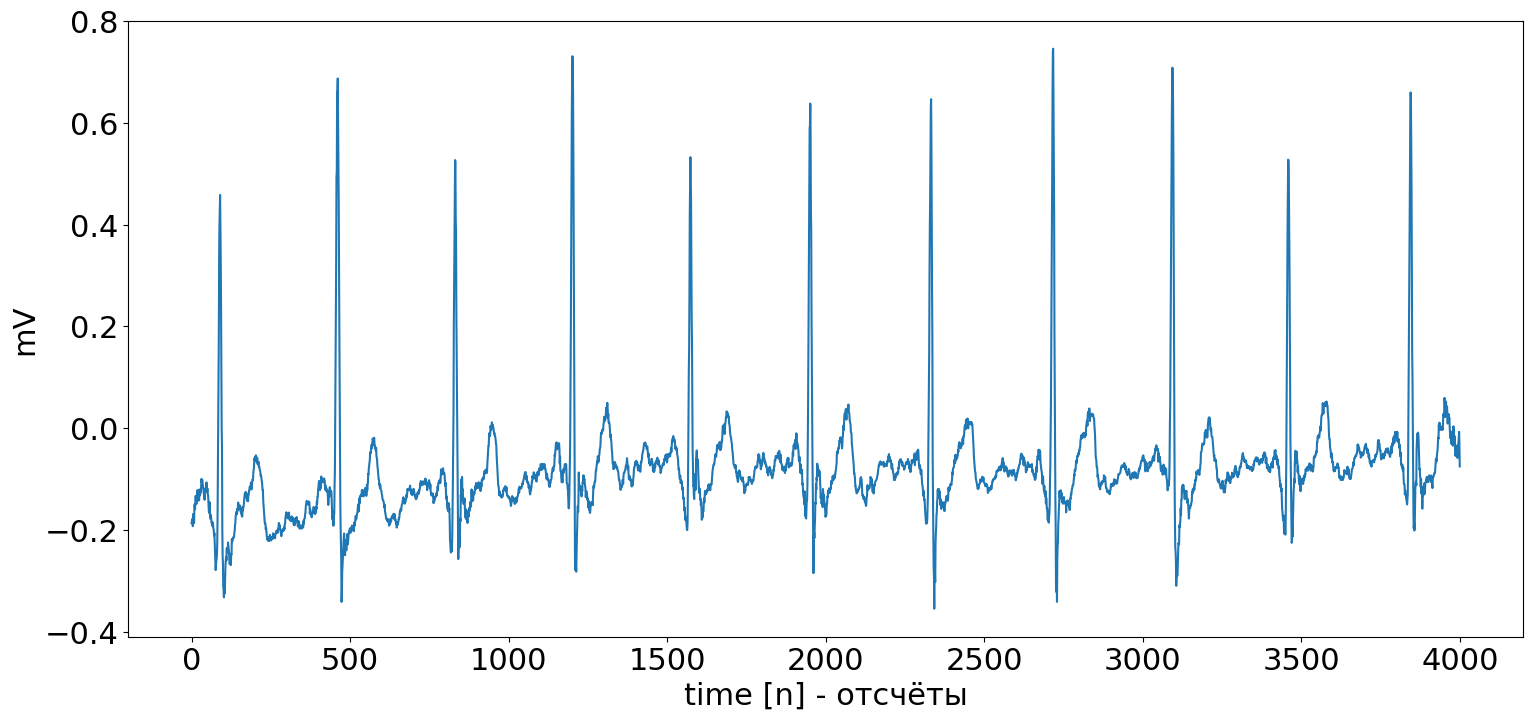

In [117]:
esig.plot_sample(gan_signal.detach().numpy())

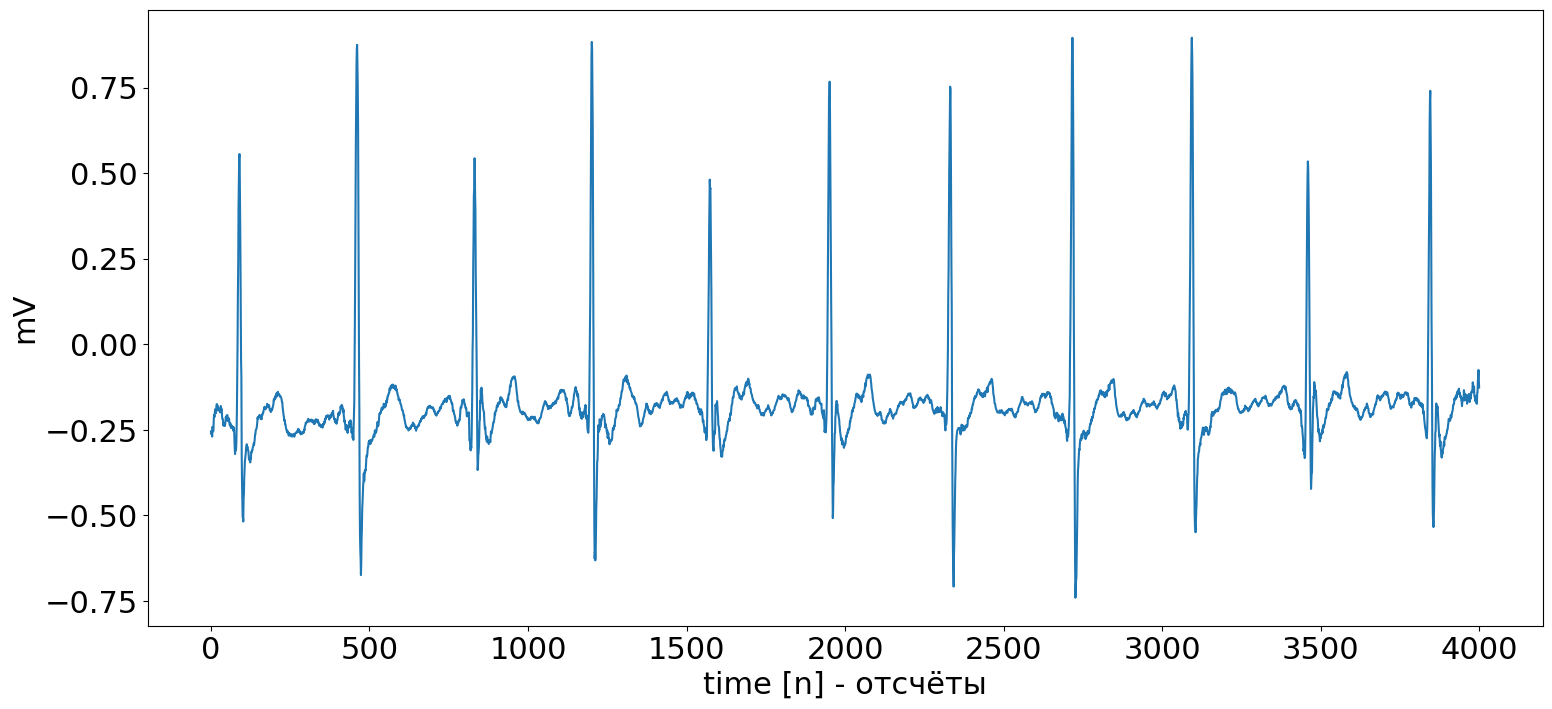

In [118]:
esig.plot_sample(gan_signal2.detach().numpy())

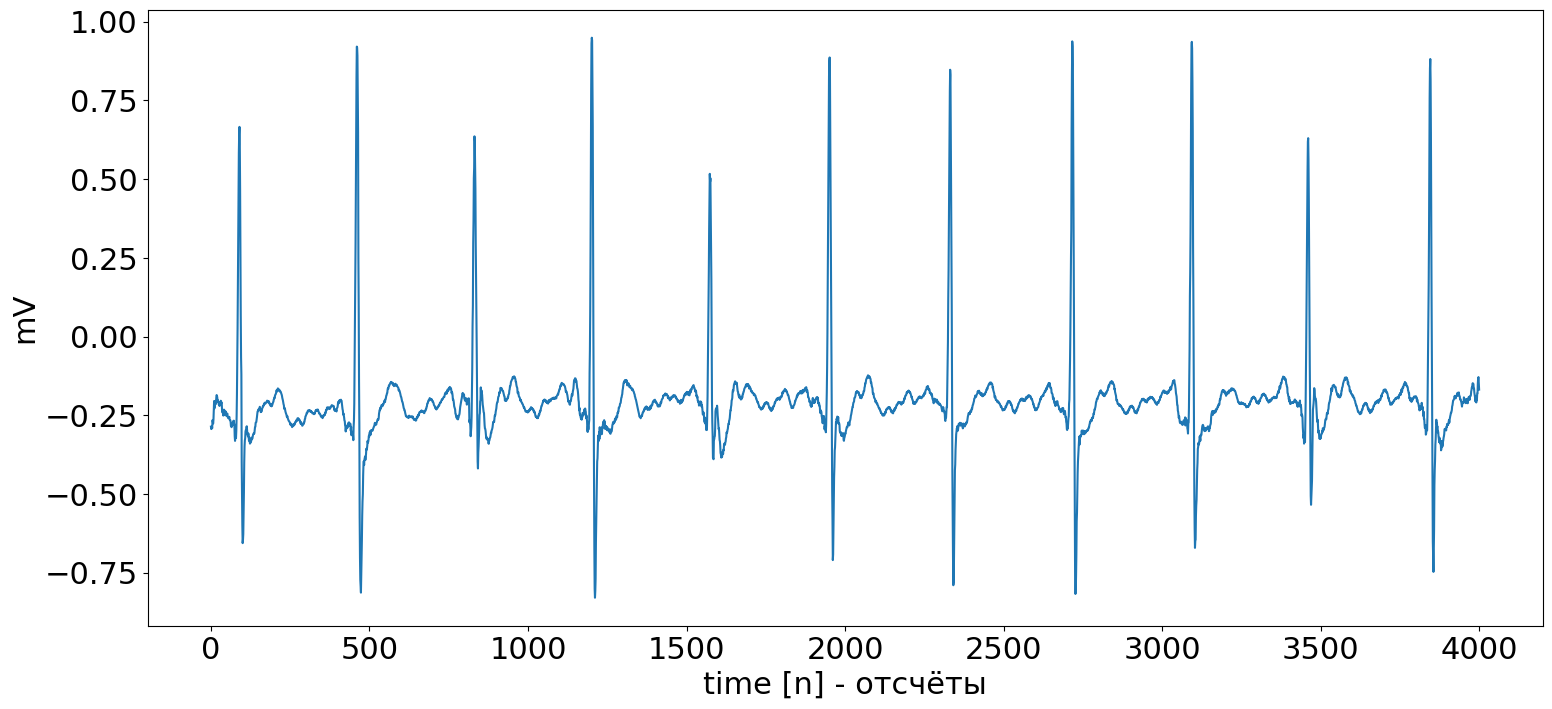

In [119]:
esig.plot_sample(gan_signal3.detach().numpy())

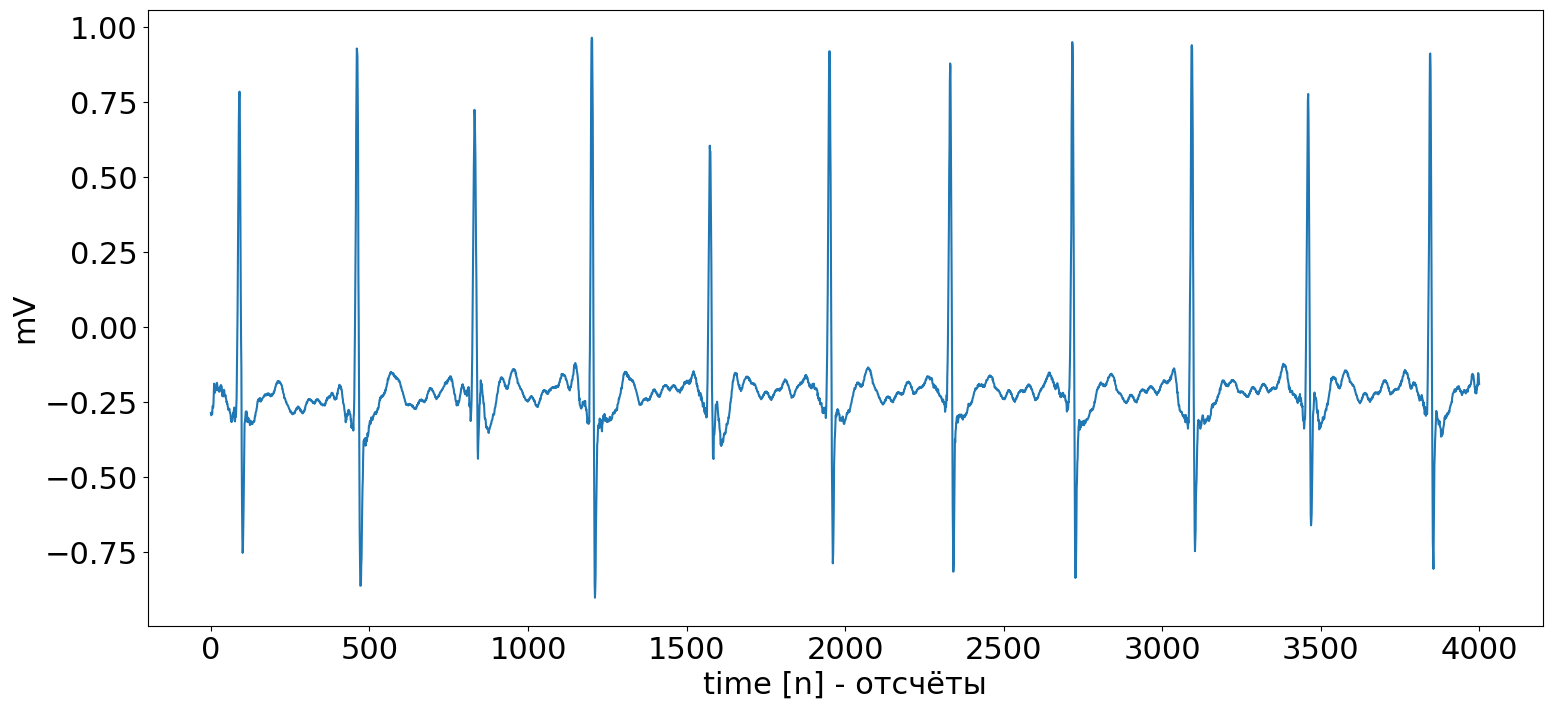

In [120]:
esig.plot_sample(gan_signal4.detach().numpy())

In [ ]:
import numpy as np
from scipy.signal import butter, lfilter

def detect_baseline_wander(ecg_signal, sampling_rate, highpass_cutoff=0.5):
  """
  Detects baseline wander in an ECG signal.

  Args:
    ecg_signal: The ECG signal as a NumPy array.
    sampling_rate: The sampling rate of the ECG signal in Hz.
    highpass_cutoff: The cutoff frequency for the highpass filter in Hz.

  Returns:
    A boolean value indicating whether baseline wander is present.
  """

  # Apply a highpass filter to remove baseline wander.
  filtered_signal = butter_highpass_filter(ecg_signal, highpass_cutoff, sampling_rate)

  # Calculate the standard deviation of the filtered signal.
  std_filtered = np.std(filtered_signal)

  # Calculate the standard deviation of the original signal.
  std_original = np.std(ecg_signal)

  # If the standard deviation of the filtered signal is significantly lower
  # than the standard deviation of the original signal, then baseline wander
  # is likely present.
  if std_filtered < 0.1 * std_original:
    return True
  else:
    return False

def butter_highpass_filter(data, cutoff, fs, order=5):
  """
  Applies a Butterworth highpass filter to the input data.

  Args:
    data: The input data as a NumPy array.
    cutoff: The cutoff frequency of the filter in Hz.
    fs: The sampling rate of the data in Hz.
    order: The order of the filter.

  Returns:
    The filtered data as a NumPy array.
  """
  nyq = 0.5 * fs
  normal_cutoff = cutoff / nyq
  b, a = butter(order, normal_cutoff, btype='high', analog=False)
  y = lfilter(b, a, data)
  return y

# Example usage:
ecg_signal = np.loadtxt("ecg_signal.txt")  # Load ECG signal from a file
sampling_rate = 1000  # Set the sampling rate of the ECG signal

if detect_baseline_wander(ecg_signal, sampling_rate):
  print("Baseline wander detected.")
else:
  print("No baseline wander detected.")